# February

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
%matplotlib inline

The mid-price:
$$ M = \frac{P^a + P^b}{2} $$ 

The weighted mid-price:
$$ W = P^b (1 - I) + P^a I $$ 

The imbalance:
$$ I = \frac{Q^b}{Q^a + Q^b} $$ 

The bid-ask spread:
$$ S = P^a - P^b $$

In [2]:
def get_df(month):
    
    file1 = 'Moex_%s.csv'%str(month)
    df = pd.read_csv(file1)
    df.columns = ['date','time','bid','bs','ask','as']       # bs, as = bid size , ask size 
    df = df.dropna()
    df['date'] = df['date'].astype(float)
    df['time'] = df['time'].astype(float)
    df['bid'] = df['bid'].astype(float)
    df['ask'] = df['ask'].astype(float)
    df['bs'] = df['bs'].astype(float)
    df['as'] = df['as'].astype(float)
    df['mid'] = (df['bid'].astype(float) + df['ask'].astype(float)) / 2                        # mid = mid-price
    df['imb'] = df['bs'].astype(float) / (df['bs'].astype(float) + df['as'].astype(float))     # imb = imbalance
    df['wmid'] = df['ask'].astype(float)*df['imb'] + df['bid'].astype(float) * (1 - df['imb'])   # wmid = weighted mid-price
    
    return df

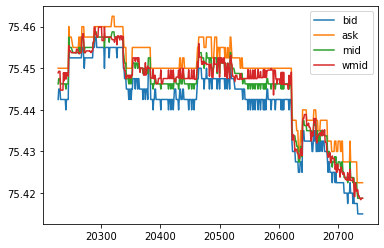

In [3]:
data = get_df('feb')[20000:20500]
data.head()
data[['bid','ask','mid','wmid']].plot()

In [4]:
month = 'feb'
data = get_df(month) 

# Переходим к подсчету micro-price

In [5]:
from scipy.linalg import block_diag
import matplotlib.pyplot as plt

In [6]:
def prep_data_sym(T, n_imb, dt, n_spread):
    
    spread = T.ask - T.bid
    #ticksize = np.round(min(spread[spread > 0]) * 100)/100
    ticksize = np.round(min(spread[spread > 0]), decimals = 4)
    
    # adds the spread and mid prices
    T['spread'] = np.round((T['ask'] - T['bid']) / ticksize) * ticksize           # считаем спред как кол-во тиков * размер тика
    # T['mid'] = (T['bid'] + T['ask'])/2   mid уже есть в подающемся на вход T
    
    #filter out spreads >= n_spread                        
    T = T.loc[(T.spread <= n_spread*ticksize) & (T.spread>0)]
    #T['imb'] = T['bs'] / (T['bs'] + T['as'])   imb уже есть в подающемся на вход T
    
    #discretize imbalance into percentiles
    T['imb_bucket'] = pd.qcut(T['imb'], n_imb, labels=False)     # на n_imb - тили разбиваем imb. дискретизируем как бы 
    T['next_mid'] = T['mid'].shift(-dt)                          # следующее значение (через время dt)
    
    #step ahead state variables
    T['next_spread'] = T['spread'].shift(-dt)
    T['next_time'] = T['time'].shift(-dt)
    T['next_imb_bucket'] = T['imb_bucket'].shift(-dt)  
    
    # step ahead change in price
    T['dM'] = np.round((T['next_mid'] - T['mid']) / ticksize*2 )*ticksize/2      # на пополам, потому что цена средняя, и когда бид или аск меняется на тик, среднее меняется на половину тика
    
    T = T.loc[(T.dM <= ticksize*1.1) & (T.dM >= -ticksize*1.1)]          
    
    
    # symetrize data
    T2 = T.copy()                                                       
    T2['imb_bucket'] = n_imb - 1 - T2['imb_bucket']
    T2['next_imb_bucket'] = n_imb - 1 - T2['next_imb_bucket']
    T2['dM'] = -T2['dM']
    T2['mid'] = -T2['mid']
    
    T3 = pd.concat([T,T2])                                                # склеиваем (подклеивам T2 снизу к Т)
    T3.index = pd.RangeIndex(len(T3.index))                               # сами устанавливаем индекс : 0, 1, 2, ...
    
    return T3, ticksize

In [7]:
def estimate(T, n_spread, n_imb):
    
    no_move = T[T['dM'] == 0]
    no_move_counts = no_move.pivot_table(index = [ 'next_imb_bucket'],               # преобразует датафрейм в сводную таблицу
                     columns = ['spread', 'imb_bucket'], 
                     values = 'time',
                     fill_value = 0, 
                     aggfunc = 'count').unstack()
    Q_counts = np.resize(np.array(no_move_counts[0:(n_imb*n_imb)]), (n_imb, n_imb))  # n_imb первое из-за imb_bucket, второе - из-за next_imb_bucket
    # по строчкам imb_bucket, по столбцам - next_imb_bucket
    # и это все для спреда = spread[0]
    
    # loop over all spreads and add block matrices
    for i in range(1, n_spread):
        Qi = np.resize(np.array( no_move_counts[(i*n_imb*n_imb) : (i+1)*(n_imb*n_imb)] ), (n_imb, n_imb))
        Q_counts = block_diag(Q_counts, Qi)
    # то же самое делаем для других возможных спредов
    # теперь Q_counts.shape = (n_spread*n_imb, n_spread*n_imb)
    
    #print Q_counts
    move_counts = T[T['dM'] != 0].pivot_table(index = ['dM'], 
                         columns = ['spread', 'imb_bucket'], 
                         values = 'time',
                         fill_value = 0, 
                         aggfunc = 'count').unstack()

    R_counts = np.resize(np.array(move_counts), (n_imb*n_spread, 4))  # 4 - потому что |K| = 4
    # посчитали количества, осталось посчитать вероятности
    
    T1 = np.concatenate((Q_counts, R_counts), axis=1).astype(float)
    for i in range(0, n_imb*n_spread):
        T1[i] = T1[i] / T1[i].sum()
    Q = T1[:, 0:(n_imb*n_spread)]
    R1 = T1[:, (n_imb*n_spread):]
    # посчитали вероятности, потому что T1[i].sum() =  сколько (X_t = x)
    
    K = np.array([-ticksize, -0.5*ticksize, 0.5*ticksize, ticksize])
    
    move_counts = T[T['dM'] != 0].pivot_table(index = ['spread','imb_bucket'], 
                     columns = ['next_spread', 'next_imb_bucket'], 
                     values = 'time',
                     fill_value = 0, 
                     aggfunc = 'count')

    R2_counts = np.resize(np.array(move_counts), (n_imb*n_spread, n_imb*n_spread))
    # R2_counts - это "матрица перехода" из одного состояния в другое
    T2 = np.concatenate((Q_counts, R2_counts), axis=1).astype(float)

    for i in range(0, n_imb*n_spread):
        T2[i] = T2[i]/T2[i].sum()
    R2 = T2[:, (n_imb*n_spread):]
    # R2 - это T_xy в обозначениях из статьи
    
    G1 = np.dot( np.dot( np.linalg.inv(np.eye(n_imb*n_spread) - Q) , R1) , K)       # np.eye - единичная матрица
    B = np.dot( np.linalg.inv(np.eye(n_imb*n_spread) - Q) , R2)
    # посчитали G1 и B из статьи по приведенным там формулам
    
    return G1, B, Q, R1, R2, K

In [8]:
def plot_Gstar_mod(ticker, G1, B, T, n_iter, ticksize):
    
    pow_B = np.identity(B.shape[0])         # единичная матрица
    G = G1
    
    k = n_iter // 3
    
    plt.figure(figsize = (20, 30))
    diff_norm = []
    
    for j in range(2, n_iter+1):
        pow_B = np.dot(pow_B, B)
        G = G + np.dot(pow_B, G1)
        diff_norm.append(np.linalg.norm(np.dot(pow_B, G1)))
        
        plt.subplot(k, 3, j-1)
        plt.plot(imb, np.linspace(-ticksize*0.5, 0.5*ticksize, n_imb) * 0, label = 'Mid adj', marker='o')
        plt.plot(imb, np.linspace(-ticksize*0.5, 0.5*ticksize, n_imb), label = 'Weighted mid adj', marker='o')     # ?????почему?????
       
        for i in range(0, n_spread):
            plt.plot(imb, G[(i*n_imb):((i+1)*n_imb)], label = "spread = "+str(i+1)+" tick adj", marker='o')

        plt.ylim(-ticksize*0.5, 0.5*ticksize)
        plt.legend(loc = 'upper left')
        plt.title('Moex in  ' + month + '  adjustments,' + ' G' + str(j))
        plt.xlabel('Imbalance')
    
    print(np.asarray(diff_norm))
    return G

In [9]:
def plot_Gstar(ticker, G1, B, T, ticksize, n_spread):
    
    pow_B = np.identity(B.shape[0])         # единичная матрица
    G = G1
    
    plt.figure(figsize = (15, 8))
    diff_norm = []
    
    pow_B = np.dot(pow_B, B)
    G = G + np.dot(pow_B, G1)
    diff_norm.append(np.linalg.norm(np.dot(pow_B, G1)))
    j = 2
    
    while (diff_norm[-1] > 1e-6):
        pow_B = np.dot(pow_B, B)
        G = G + np.dot(pow_B, G1)
        diff_norm.append(np.linalg.norm(np.dot(pow_B, G1)))
        j += 1
        
    plt.plot(imb, np.linspace(-ticksize*0.5, 0.5*ticksize, n_imb) * 0, label = 'Mid adj', marker='o', linewidth = 7)
    plt.plot(imb, np.linspace(-ticksize*0.5, 0.5*ticksize, n_imb), label = 'Weighted mid adj for 1 spread', marker='o', linewidth = 7)     # ?????почему?????
    plt.plot(imb, np.linspace(-ticksize*n_spread*0.5, 0.5*n_spread*ticksize, n_imb), label = 'Weighted mid adj for spread {}'.format(n_spread), marker='o', linewidth = 7)     # ?????почему?????
       
    for i in range(0, n_spread):
        plt.plot(imb, G[(i*n_imb):((i+1)*n_imb)], label = "spread = "+str(i+1)+" tick adj", marker='o')

    plt.ylim(-ticksize*0.5, 0.5*ticksize)
    plt.legend(loc = 'upper left')
    plt.title('Moex in  ' + month + '  adjustments,' + ' G' + str(j))
    plt.xlabel('Imbalance')
    
    print(np.asarray(diff_norm))
    return G

In [10]:
def prep_data_and_count_microprice(T, G, n_imb, dt, n_spread):
    
    spread = T.ask - T.bid
    #ticksize = np.round(min(spread[spread > 0]) * 100)/100
    ticksize = np.round(min(spread[spread > 0]), decimals = 4)
    
    # adds the spread and mid prices
    T['spread'] = np.round((T['ask'] - T['bid']) / ticksize) * ticksize           # считаем спред как кол-во тиков * размер тика
    # T['mid'] = (T['bid'] + T['ask'])/2   mid уже есть в подающемся на вход T
    
    #filter out spreads >= n_spread                        
    T = T.loc[(T.spread <= n_spread*ticksize) & (T.spread>0)]
    #T['imb'] = T['bs'] / (T['bs'] + T['as'])   imb уже есть в подающемся на вход T
    
    #discretize imbalance into percentiles
    T['imb_bucket'] = pd.qcut(T['imb'], n_imb, labels=False)     # на n_imb - тили разбиваем imb. дискретизируем как бы
    
    # add microprice
    for i in range(n_spread):
        for j in range(n_imb):
            mask = (T['imb_bucket'] == j) & (T['spread'] == i*ticksize)
             
            T.loc[mask, 'mpr'] = T['mid'] + G[i*n_imb + j]
    
    
    T['next_mid'] = T['mid'].shift(-dt)                          # следующее значение (через время dt)
    
    #step ahead state variables
    T['next_spread'] = T['spread'].shift(-dt)
    T['next_time'] = T['time'].shift(-dt)
    T['next_imb_bucket'] = T['imb_bucket'].shift(-dt)  
    
    # step ahead change in price
    T['dM'] = np.round((T['next_mid'] - T['mid']) / ticksize*2 )*ticksize/2      # на пополам, потому что цена средняя, и когда бид или аск меняется на тик, среднее меняется на половину тика
    
    T['dMpr'] = T['mpr'].shift(-dt) - T['mpr']
    T['dW'] = T['wmid'].shift(-dt) - T['wmid']
    
    T = T.loc[(T.dM <= ticksize*1.1) & (T.dM >= -ticksize*1.1)]          
    
    T2 = T.copy()
    
    return T2

In [11]:
def autocorr(T, G, n_imb, n_spread, ticksize, dt):
    df = T.copy()
    
    arr = df['dMpr']
    print("Автокорреляция для micro-price = ", arr.autocorr(lag = 1))
    
    arr = df['dM']
    print("Автокорреляция для mid price = ", arr.autocorr(lag = 1))
    
    arr = df['dW']
    print("Автокорреляция для w mid price = ", arr.autocorr(lag = 1))
    

In [12]:
# Добавить проверку на приращение (среднее приращение на разных траекториях)
# мартингальность проверить
# autocorr должен быть меньше у микро

# FEB

In [13]:
month = 'feb'
data = get_df(month) 

n_imb = 10   # с потолка
dt = 1      # смотрим изменение за одну секунду

In [14]:
spread = data.ask - data.bid
#ticksize = np.round(min(spread[spread > 0]) * 100)/100
ticksize = np.round(min(spread[spread > 0]), decimals = 4)
    
# adds the spread and mid prices
data['spread'] = np.round((data['ask'] - data['bid']) / ticksize) * ticksize           # считаем спред как кол-во тиков * размер тика
# T['mid'] = (T['bid'] + T['ask'])/2   mid уже есть в подающемся на вход T

In [15]:
data['spread']

0         0.0300
1         0.0175
2         0.0225
3         0.0225
4         0.0225
           ...  
982794    0.0025
982795    0.0025
982796    0.0025
982797    0.0025
982798    0.0025
Name: spread, Length: 316166, dtype: float64

Возьмем 95% квантиль

In [16]:
quant = np.quantile(data['spread'], 0.95)
quant

0.0175

Поймем, какое устанавливать значение для $n\_spread$

In [17]:
pd.set_option('mode.chained_assignment', None)
import warnings
warnings.simplefilter(action = 'ignore', category = UserWarning)

In [18]:
n = 2
n_spread = n
T_feb, ticksize = prep_data_sym(data, n_imb, dt, n_spread=n)

while (np.histogram_bin_edges(T_feb['spread'], bins = n).max() <= quant):
    n += 1
    T_feb, ticksize = prep_data_sym(data, n_imb, dt, n_spread = n)

n_spread = n - 1
n_spread

7

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000209A3D70FA0>]],
      dtype=object)

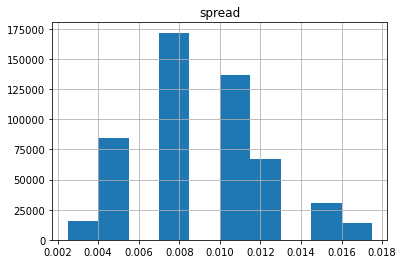

In [19]:
T_feb, ticksize = prep_data_sym(data, n_imb, dt, n_spread)
T_feb.hist('spread')

Таким образом, выделяются 7 спредов

In [20]:
T_feb, ticksize = prep_data_sym(data, n_imb, dt, n_spread)

[7.09222608e-04 2.11836795e-04 6.43998944e-05 1.91972633e-05
 5.61967213e-06 1.62051678e-06 4.62410187e-07]


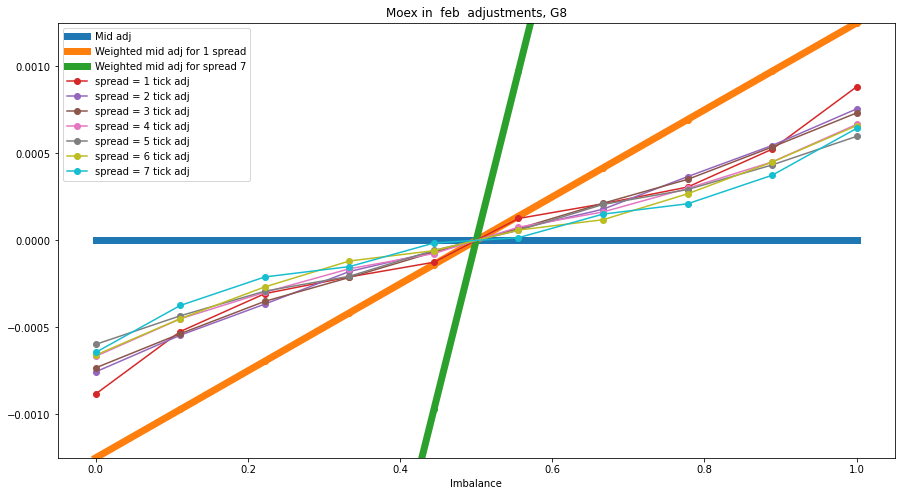

In [21]:
imb = np.linspace(0, 1, n_imb)
G1, B, Q, R1, R2, K = estimate(T_feb, n_spread, n_imb)

G = plot_Gstar(month, G1, B, T_feb, ticksize, n_spread)
plt.show()

In [22]:
T_feb

,date,time,bid,bs,ask,as,mid,imb,wmid,spread,imb_bucket,next_mid,next_spread,next_time,next_imb_bucket,dM
0,19030.0,36017.0,75.7425,10000.0,75.7575,330000.0,75.75000,0.029412,75.742941,0.0150,0,75.74875,0.0175,36018.0,0.0,-0.00125
1,19030.0,36018.0,75.7400,51000.0,75.7575,330000.0,75.74875,0.133858,75.742343,0.0175,0,75.74875,0.0175,36019.0,0.0,0.00000
2,19030.0,36020.0,75.7350,350000.0,75.7525,150000.0,75.74375,0.700000,75.747250,0.0175,7,75.74500,0.0150,36021.0,4.0,0.00125
3,19030.0,36021.0,75.7375,150000.0,75.7525,150000.0,75.74500,0.500000,75.745000,0.0150,4,75.74500,0.0150,36022.0,5.0,0.00000
4,19030.0,36022.0,75.7375,150000.0,75.7525,100000.0,75.74500,0.600000,75.746500,0.0150,5,75.74250,0.0150,36023.0,9.0,-0.00250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520779,19041.0,68394.0,76.9500,562000.0,76.9525,55000.0,-76.95125,0.910859,76.952277,0.0025,0,76.95125,0.0025,68395.0,0.0,-0.00000
520780,19041.0,68395.0,76.9500,562000.0,76.9525,55000.0,-76.95125,0.910859,76.952277,0.0025,0,76.95125,0.0025,68396.0,0.0,-0.00000
520781,19041.0,68396.0,76.9500,564000.0,76.9525,54000.0,-76.95125,0.912621,76.952282,0.0025,0,76.95125,0.0025,68397.0,0.0,-0.00000
520782,19041.0,68397.0,76.9500,564000.0,76.9525,54000.0,-76.95125,0.912621,76.952282,0.0025,0,76.95125,0.0025,68398.0,0.0,-0.00000


## Прогнозы изменения средней цены

Теперь хотим понять, как хорошо micro-price предсказывает изменение средней цены ($M_t$) за временные промежутки t1 = 30 секунд, t2 = 60 секунд

In [23]:
def prep_data_sym_mod(T, n_imb, dt, t1, t2, n_spread):
    
    spread = T.ask - T.bid
    #ticksize = np.round(min(spread[spread > 0]) * 100)/100
    ticksize = np.round(min(spread[spread > 0]), decimals = 4)
    
    # adds the spread and mid prices
    T['spread'] = np.round((T['ask'] - T['bid']) / ticksize) * ticksize           # считаем спред как кол-во тиков * размер тика
    # T['mid'] = (T['bid'] + T['ask'])/2   mid уже есть в подающемся на вход T
    
    #filter out spreads >= n_spread                        # что такое n_spread?
    T = T.loc[(T.spread <= n_spread*ticksize) & (T.spread>0)]
    #T['imb'] = T['bs'] / (T['bs'] + T['as'])   imb уже есть в подающемся на вход T
    
    #discretize imbalance into percentiles
    T['imb_bucket'] = pd.qcut(T['imb'], n_imb, labels=False)     # на n_imb - тили разбиваем имбаланс. дискретизируем как бы 
    T['next_mid'] = T['mid'].shift(-dt)                          # следующее значение (через время dt)
    
    #step ahead state variables
    T['next_spread'] = T['spread'].shift(-dt)
    T['next_time'] = T['time'].shift(-dt)
    T['next_imb_bucket'] = T['imb_bucket'].shift(-dt)  
    
    T['next_t1_mid'] = T['mid'].shift(-t1)
    T['dM_t1_sec'] = np.round((T['next_t1_mid'] - T['mid']) / ticksize*t1 )*ticksize/t1
    
    T['next_t2_mid'] = T['mid'].shift(-t2)
    T['dM_t2_sec'] = np.round((T['next_t2_mid'] - T['mid']) / ticksize*t2 )*ticksize/t2
    
    
    # step ahead change in price
    T['dM'] = np.round((T['next_mid'] - T['mid']) / ticksize*2 )*ticksize/2      # на пополам, потому что цена средняя, и когда бид или аск меняется на тик, среднее меняется на половину тика
    
    # ????? Почему так ?????
    T = T[(T.dM <= ticksize*1.1) & (T.dM >= -ticksize*1.1)]           # это нормальное предположение? почему только изменение на 1.1 тик допустимо?
    
    # symetrize data
    T2 = T.copy()                                                     # T2 - 'симметрично' T, то есть бид и аск меняем местами
    T2['imb_bucket'] = n_imb - 1 - T2['imb_bucket']
    T2['next_imb_bucket'] = n_imb - 1 - T2['next_imb_bucket']
    T2['dM'] = -T2['dM']
    T2['mid'] = -T2['mid']
    T2['dM_t1_sec'] = -T2['dM_t1_sec']
    T2['next_t1_mid'] = - T2['next_t1_mid']
    T2['dM_t2_sec'] = -T2['dM_t2_sec']
    T2['next_t2_mid'] = - T2['next_t2_mid']
    
    T3 = pd.concat([T,T2])                                                # склеиваем (подклеивам T2 снизу к Т)
    T3.index = pd.RangeIndex(len(T3.index))                               # сами устанавливаем индекс : 0, 1, 2, ...
    
    return T3, ticksize

In [24]:
t1 = 30
t2 = 60

T_feb, ticksize = prep_data_sym_mod(data, n_imb, dt, t1, t2, n_spread)

[7.09222608e-04 2.11836795e-04 6.43998944e-05 1.91972633e-05
 5.61967213e-06 1.62051678e-06 4.62410187e-07]


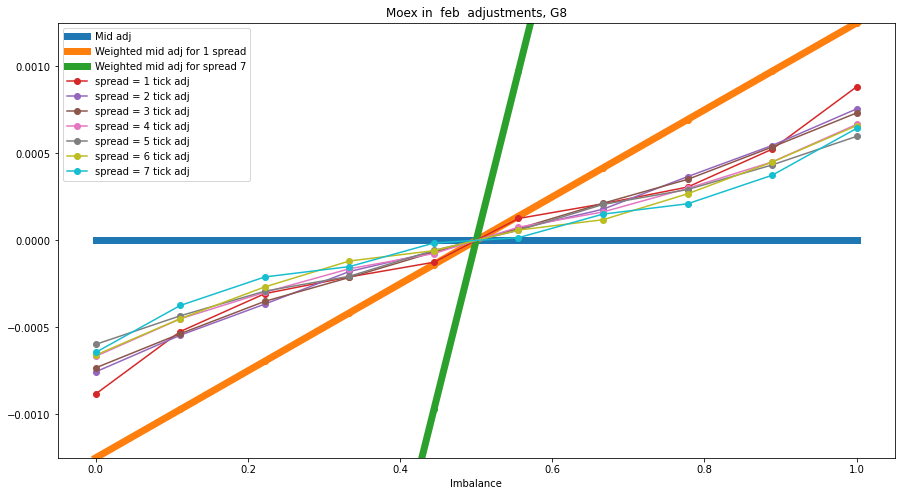

In [25]:
G = plot_Gstar(month, G1, B, T_feb, ticksize, n_spread)

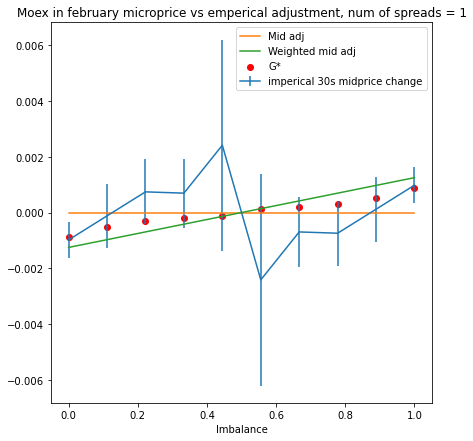

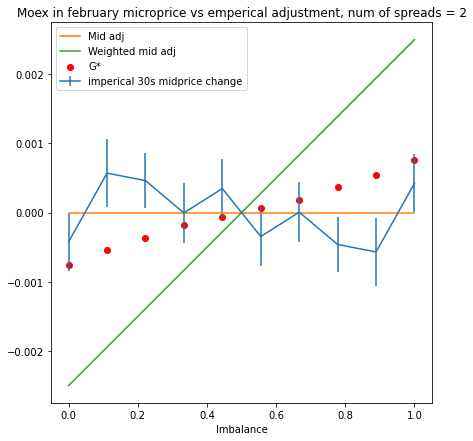

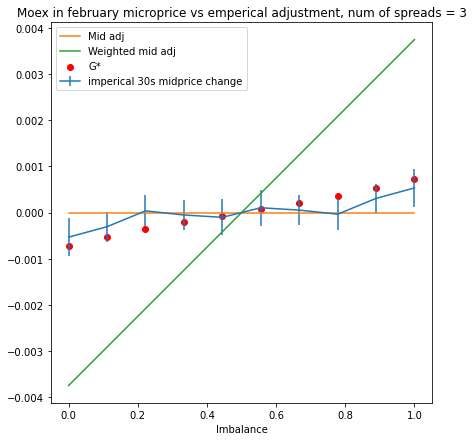

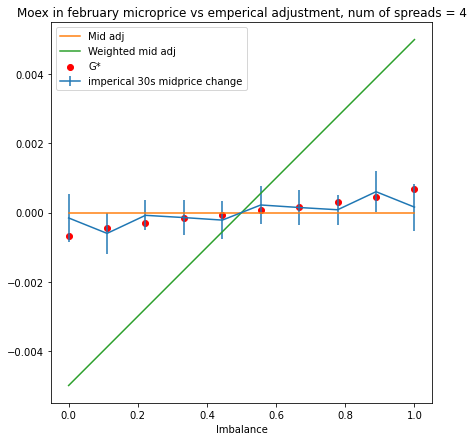

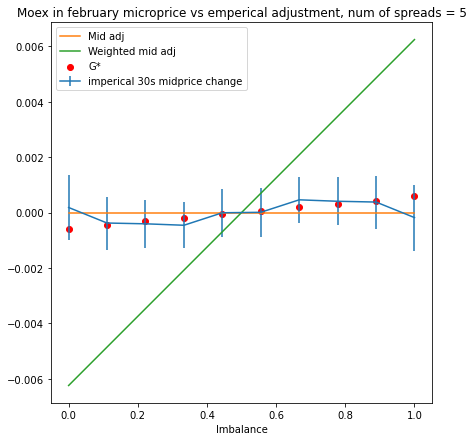

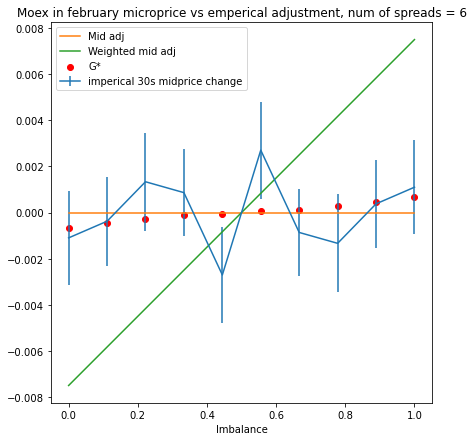

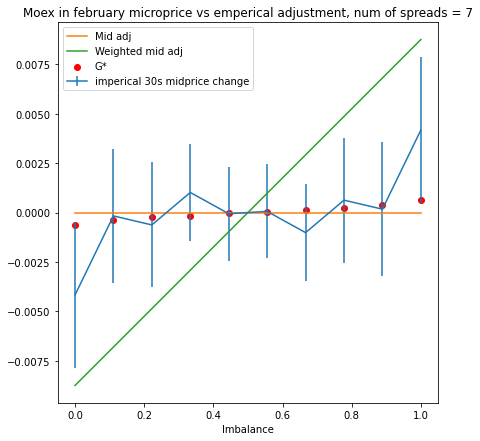

In [29]:
# уровень доверительного интервала
alpha = 0.99

tmp1 = np.zeros((n_spread, n_imb))
tmp2 = np.zeros((n_spread, n_imb))

tmp3 = np.zeros((n_spread, n_imb))
tmp4 = np.zeros((n_spread, n_imb))

for i in range(1, n_spread+1):
    for j in range(n_imb):
        df = T_feb[(T_feb['imb_bucket'] == j) & (T_feb['spread'] == i*ticksize)]
        tmp1[i-1][j] = df.dM_t1_sec.dropna().mean()
        std = df.dM_t1_sec.dropna().std()
        interval = stats.norm.interval(alpha=alpha, loc = tmp1[i-1][j], scale = std/np.sqrt(len(df)))
        tmp2[i-1][j] = 0.5*(interval[1] - interval[0])
        
        tmp3[i-1][j] = df.dM_t2_sec.dropna().mean()
        std = df.dM_t2_sec.dropna().std()
        interval = stats.norm.interval(alpha=alpha, loc = tmp1[i-1][j], scale = std/np.sqrt(len(df)))
        tmp4[i-1][j] = 0.5*(interval[1] - interval[0])
        
for i in range(1, n_spread+1):
    plt.figure(figsize = (15, 7))
    
    plt.subplot(1,2,1)
    
    plt.errorbar(imb, tmp1[i-1], yerr = tmp2[i-1], label = 'imperical {}s midprice change'.format(t1))
    plt.scatter(imb, G[((i-1)*n_imb):(i*n_imb)], color = 'red', label = 'G*')
    plt.plot(imb, np.linspace(-ticksize*0.5*i, 0.5*ticksize*i, n_imb) * 0, label = 'Mid adj')
    plt.plot(imb, np.linspace(-ticksize*0.5*i, 0.5*ticksize*i, n_imb), label = 'Weighted mid adj')
    plt.xlabel('Imbalance')
    plt.legend()
    plt.title('Moex in february microprice vs emperical adjustment, num of spreads = ' + str(i))
    
    '''plt.subplot(1,2,2)
    
    plt.errorbar(imb, tmp3[i-1], yerr = tmp4[i-1], label = 'imperical {}s midprice change'.format(t2))
    plt.scatter(imb, G[((i-1)*n_imb):(i*n_imb)], color = 'red', label = 'G*')
    plt.plot(imb, np.linspace(-ticksize*0.5*i, 0.5*ticksize*i, n_imb) * 0, label = 'Mid adj')
    plt.plot(imb, np.linspace(-ticksize*0.5*i, 0.5*ticksize*i, n_imb), label = 'Weighted mid adj')
    plt.xlabel('Imbalance')
    plt.legend()
    plt.title('Moex in february microprice vs emperical adjustment, num of spreads = ' + str(i))
    '''
    plt.show()

## Корреляция

In [27]:
data = get_df(month)
new = prep_data_and_count_microprice(data, G, n_imb, dt, n_spread)
autocorr(new, G, n_imb, n_spread, ticksize, dt)

Автокорреляция для micro-price =  -0.042844296702894656
Автокорреляция для mid price =  -0.04529954331641669
Автокорреляция для w mid price =  -0.18209023117549358


Для микропрайса автокорреляция наименьшая!

# Приращения

In [28]:
date = new['date'].unique()

arr_dM = []
arr_dW = []
arr_dMpr = []


for d in date:
    arr_dM.append(new.loc[new['date'] == d].dM.mean())
    arr_dW.append(new.loc[new['date'] == d].dW.mean())
    arr_dMpr.append(new.loc[new['date'] == d].dMpr.mean())

In [29]:
arr_dM

[-1.509460455646428e-05,
 -2.741014086506019e-05,
 -2.8760362512294094e-05,
 -3.98874603796426e-05,
 -3.811545944327995e-05,
 -5.979619757512772e-05,
 -3.6808860815799586e-05,
 -2.9582737602528137e-05,
 -3.9298018949181705e-06,
 -1.7472470431203813e-05]

In [30]:
arr_dW

[-2.943909850612939e-05,
 -3.3476664832740167e-05,
 -3.108943247761864e-05,
 -4.05099082429758e-05,
 -5.656585406042844e-05,
 -9.723324931065057e-05,
 -4.224708598788585e-05,
 -4.874435127164603e-05,
 -2.8608567338410112e-05,
 -1.7234856281973365e-05]

In [31]:
arr_dMpr

[-1.603663927186296e-05,
 -2.715930619316124e-05,
 -2.8925320951685644e-05,
 -3.9496255941276374e-05,
 -4.001146038606248e-05,
 -5.936268325149383e-05,
 -3.5251516803522135e-05,
 -3.097434786038028e-05,
 -5.4979917821681045e-06,
 -1.7469229332356414e-05]